In [ ]:
import os
import io
import json
from langgraph.graph import StateGraph, START, END, MessagesState
import pandas as pd
from IPython.display import Image, display
from PIL import Image as pil_image
import pytesseract
import pdfplumber
from dataclasses import dataclass
from typing import Literal
from langchain_openai import ChatOpenAI

In [ ]:
os.environ["OPENAI_API_KEY"] = "set_key"
os.environ["LANGSMITH_API_KEY"] = "set_key"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "phi-detector"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

# Input State

In [3]:
@dataclass
class docState(MessagesState):
    input: bytes
    file_ext: str
    text: str
    instances: list[list]
    exclude_filter: list

# Get File Bytes

In [4]:
def get_file_data(file_path):
    with open(file_path, "rb") as f:
        file_bytes = f.read()
    file_ext = file_path.lower().split('.')[-1]
    return file_bytes, file_ext

# Router

In [5]:
def input_router(doc_state) -> Literal["OCR", "PDF Parser", "CSV Parser"]:
    file_ext = doc_state["file_ext"]
    if file_ext == "png":
        return "OCR"
    elif file_ext == "pdf":
        return "PDF Parser"
    elif file_ext == "csv":
        return "CSV Parser"
    else:
        raise "Invalid file type"

# OCR Tool

In [6]:
def ocr_tool(doc_state):
    image = pil_image.open(io.BytesIO(doc_state["input"]))
    text = pytesseract.image_to_string(image).strip()
    text = text.replace("\n", " ")
    doc_state["text"] = text
    return doc_state

# PDF Parser

In [7]:
def pdf_parser_tool(doc_state):
    text = ""
    with pdfplumber.open(io.BytesIO(doc_state["input"])) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ""
    doc_state["text"] = text
    return doc_state

# CSV Parser

In [8]:
def csv_parser_tool(doc_state):
    df = pd.read_csv(io.BytesIO(doc_state["input"]))
    text = ""
    for row in df.iterrows():
        text += f"Index: {row[0]}\n"
        for item,col in zip(row[1].values,df.columns):
            text += f"{col}: {item}\n"
        text += "\n"
    doc_state["text"] = text
    return doc_state

# Initialize LLM

In [9]:
llm = ChatOpenAI(model = "gpt-4o")

# PHI Identifier

In [10]:
def get_exclusion(filter_list):
    text = "."
    if filter_list:
        text += "except PHI instances of the type"
        for item in filter_list[:-1]:
            text += f" {item},"
        if len(filter_list) > 1:
            text += " and"
        text += f" {filter_list[-1]}."
    return text

In [67]:
def phi_identifier(doc_state):
    prompt = ("You are a Personal Health Identifier (PHI) detection agent. "
              f"List all instances of PHI in the text below{get_exclusion(doc_state['exclude_filter'])}" 
              "For each, return a JSON object with 'type', 'value', 'start' and 'end' (character positions in text)."
              "Return ONLY a valid JSON array, no other text."
              "Text:\n" + doc_state['text'])
    
    response = llm.invoke(prompt)
    content = response.content

    try:
        if content.strip().startswith('['):
            phi_instances = json.loads(content.strip())
        else:
            json_start = content.find('[') 
            json_end = content.rfind(']') + 1
            if json_start >= 0 and json_end > json_start:
                phi_instances = json.loads(content[json_start:json_end])
            else:
                phi_instances = []
        doc_state["instances"].append(phi_instances)
    except Exception:
        doc_state["instances"].append([])
    return doc_state

# PHI rationale

In [12]:
phi_ref_list = ["Social Security numbers", "Medical record numbers, health plan numbers", "Account numbers", "Biometric identifiers (finger/voice prints)", "Names",
                "Full face photographic/comparable images", "Dates (except year), ages >89", "Geographic subdivisions < state", "Certificate/license numbers", "Vehicle identifiers",
                "Device identifiers", "Telephone numbers", "Fax numbers", "Email addresses", "Web URLs, IP addresses", "Any other unique identifying number/code"]

In [77]:
def phi_rationale(doc_state):
    prompt = ("You are a Personal Health Identifier (PHI) risk assessment agent. "
              "Analyze each item in the following list of PHI instances, classify it into a type of PHI using the PHI type reference list, and provide a single line rationale behind the PHI risk it poses."
              "If the PHI type is None then remove the item"
              "For each, append the original JSON object with 'PHI type', and 'PHI risk rationale'. Return ONLY a valid JSON array, no other text."
              f"PHI type reference list: {phi_ref_list}"
              f"PHI instances:\n {doc_state['instances'][-1]}")
    
    response = llm.invoke(prompt)
    content = response.content.strip()

    try:
        if content.strip().startswith('['):
            phi_instances = json.loads(content)
        else:
            json_start = content.find('[') 
            json_end = content.rfind(']') + 1
            if json_start >= 0 and json_end > json_start:
                phi_instances = json.loads(content[json_start:json_end])
            else:
                phi_instances = doc_state["instances"][-1]
        doc_state["instances"].append(phi_instances)
    except Exception:
        doc_state["instances"].append(doc_state["instances"][-1])
    return doc_state

# Helper Functions

## Clean json string

In [51]:
def extract_dict(text: str):
    lines = text.splitlines()
    instances_dict = "".join(lines[1:-1]).replace("\'", "\"")
    instances = json.loads(instances_dict)
    return instances

# Graph

In [78]:
graph = StateGraph(state_schema=docState)

In [79]:
graph.add_node("OCR", ocr_tool)
graph.add_node("PDF Parser", pdf_parser_tool)
graph.add_node("CSV Parser", csv_parser_tool)
graph.add_node("PHI Identifier", phi_identifier)
graph.add_node("PHI Rationale", phi_rationale)

In [80]:
graph.add_conditional_edges(START, input_router)
graph.add_edge("OCR", "PHI Identifier")
graph.add_edge("PDF Parser", "PHI Identifier")
graph.add_edge("CSV Parser", "PHI Identifier")
graph.add_edge("PHI Identifier", "PHI Rationale")
graph.add_edge("PHI Rationale", END)

In [81]:
flow_graph = graph.compile()

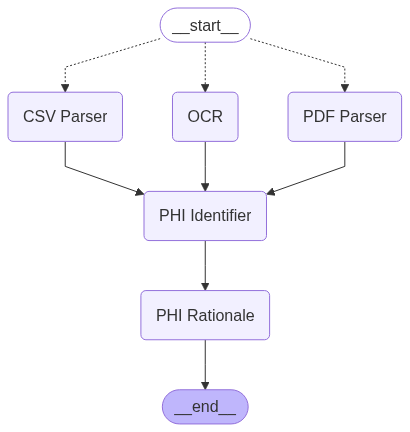

In [82]:
display(Image(flow_graph.get_graph(xray=True).draw_mermaid_png()))

# Run

In [83]:
def run_flow(file_path = "handwritten_note_generated.png", exclude_filter = []):
    file_bytes, file_ext = get_file_data(file_path = file_path)
    doc_state = docState(input = file_bytes, file_ext = file_ext, text = "", instances = [], exclude_filter = exclude_filter)
    result = flow_graph.invoke(doc_state)
    phi_instances = result["instances"][-1]
    orig_text = result["text"]

    if type(phi_instances) != list:
        try:
            phi_instances = extract_dict(phi_instances)
        except:
            pass
    return orig_text, phi_instances

In [84]:
orig_text, instances = run_flow()

In [85]:
orig_text

'Mr. John Smith (Patient ID: 006679) has an appointment on 6th June for chills, fever and body ache. Please contact Dr. Doe +18003001000 for more information.'

In [86]:
instances

[{'type': 'Name',
  'value': 'John Smith',
  'start': 4,
  'end': 14,
  'PHI type': 'Names',
  'PHI risk rationale': 'Names can directly identify individuals and reveal personal information.'},
 {'type': 'Patient ID',
  'value': '006679',
  'start': 28,
  'end': 34,
  'PHI type': 'Medical record numbers, health plan numbers',
  'PHI risk rationale': 'Patient IDs are unique identifiers that can be linked to medical records.'},
 {'type': 'Date',
  'value': '6th June',
  'start': 60,
  'end': 68,
  'PHI type': 'Dates (except year), ages >89',
  'PHI risk rationale': 'Specific dates can be used to infer or match personal information.'},
 {'type': 'Name',
  'value': 'Dr. Doe',
  'start': 102,
  'end': 109,
  'PHI type': 'Names',
  'PHI risk rationale': 'Names can directly identify individuals and reveal personal information.'},
 {'type': 'Phone Number',
  'value': '+18003001000',
  'start': 110,
  'end': 122,
  'PHI type': 'Telephone numbers',
  'PHI risk rationale': 'Phone numbers can be u

# Step-by-step-run

In [ ]:
file_bytes, file_ext = get_file_data(file_path = "handwritten_note_generated.png")
# file_bytes, file_ext = get_file_data(file_path = "Note draft.pdf")
# file_bytes, file_ext = get_file_data(file_path = "sample_sheet.csv")

In [ ]:
doc_state = docState(input = file_bytes, file_ext = file_ext, text = "", instances = [], deidentified_text = "", exclude_filter=[])

In [ ]:
result = flow_graph.invoke(doc_state)

In [ ]:
result["instances"][-1]

[{'type': 'Name',
  'value': 'John Smith',
  'start': 4,
  'end': 14,
  'PHI type': 'Names',
  'PHI risk rationale': 'Directly identifies an individual, posing a risk of personal identification.'},
 {'type': 'Date',
  'value': '6th June',
  'start': 57,
  'end': 65,
  'PHI type': 'Dates (except year), ages >89',
  'PHI risk rationale': 'Specifying a date can be used to identify individuals when combined with other information.'},
 {'type': 'Name',
  'value': 'Dr. Doe',
  'start': 115,
  'end': 122,
  'PHI type': 'Names',
  'PHI risk rationale': 'Names can be used to identify health professionals and potentially link them to individuals.'},
 {'type': 'Phone Number',
  'value': '+18003001000',
  'start': 123,
  'end': 135,
  'PHI type': 'Telephone numbers',
  'PHI risk rationale': 'Can be used to contact or trace individuals, posing a privacy risk.'}]